In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import sys, os

#sys.path.append(os.path.abspath(os.path.join("../..")))
sys.path.append(os.path.abspath(os.path.join("../scripts")))

In [3]:
import explore
import plot
import clean

In [4]:
cleaned = clean.clean()

# Import The Data

In [5]:
# Data that contains information about the completed orders

data_url = explore.get_data_url("data/complete_orders.csv", "v1.0")
complete_orders = pd.read_csv(data_url)

In [6]:
# Data that contains information about the incomplete orders

data_url = explore.get_data_url("data/missing_orders.csv", "v1.0")
incomplete_orders = pd.read_csv(data_url)

In [7]:
# data driver locations during requests 

data_url = explore.get_data_url("data/clean_driver_locations.csv", "v1.0")
driver_locations = pd.read_csv(data_url)

# Calculate Trips' distances and time durations

## 1. Clean Up latitude and Longitude Data

- First we import geopy to handle coordinates
- Second compare location data to expected values in Lagos, Nigeria

In [8]:
from geopy.geocoders import Nominatim

# Initialize Nominatim API
geolocator = Nominatim(user_agent="MyApp")

boundingbox is a comma separated list of min latitude, max latitude, min longitude, max longitude [see reference](https://nominatim.org/release-docs/develop/api/Output/#boundingbox)

In [9]:
location = geolocator.geocode("Lagos")

lagos_bbox = location.raw['boundingbox']

print("Locations within Lagos-Nigeria are bounded by these values:")
print("latidude: {} - {} \nlongitude: {} - {}".format(*lagos_bbox))



location = geolocator.geocode("Nigeria")

nigeria_bbox = location.raw['boundingbox']

print("\nLocations within Nigeria are bounded by these values:")
print("latidude: {} - {} \nlongitude: {} - {}".format(*nigeria_bbox))


Locations within Lagos-Nigeria are bounded by these values:
latidude: 6.2950575 - 6.6150575 
longitude: 3.2341795 - 3.5541795

Locations within Nigeria are bounded by these values:
latidude: 4.0690959 - 13.885645 
longitude: 2.676932 - 14.678014


Bounds for Lagos-Nigeria should represent soft bounds for our data. We expect locations to be more or less within Lagos bounds.

Hard bounds are represented by bounds for the country of Nigeria. No correct value can exceed these bounds

### 1. complete_orders

In [10]:
# We drop trips whose coordinate fall out of Nigeria boundingbox

print("For coordinates of trip origin:")
complete_orders = cleaned.out_bounds(complete_orders, 'origin_lat', 'origin_lng', nigeria_bbox, drop=True)

print("For coordinates of trip destination:")
complete_orders = cleaned.out_bounds(complete_orders, 'destination_lat', 'destination_lng', nigeria_bbox, drop=True)

For coordinates of trip origin:
There are 0 coordinate values out of bounds, accounting to 0.00% of records.
For coordinates of trip destination:
There are 1 coordinate values out of bounds, accounting to 0.00% of records.


In [11]:
# Trips whose coordinates fall out of Lagos boundingbox

print("For coordinates of trip origin:")
complete_orders = cleaned.out_bounds(complete_orders, 'origin_lat', 'origin_lng', lagos_bbox, drop=False)

print("For coordinates of trip destination:")
complete_orders = cleaned.out_bounds(complete_orders, 'destination_lat', 'destination_lng', lagos_bbox, drop=False)

For coordinates of trip origin:
There are 98891 coordinate values out of bounds, accounting to 18.51% of records.
For coordinates of trip destination:
There are 118894 coordinate values out of bounds, accounting to 22.25% of records.


18.5% of completed orders originate outside of Lagos
22.3% of completed orders go to locations outside of Lagos

### 2. driver_locations

In [12]:
print("Dirvers whose locations at requests fall out of Nigeria boundingbox")

driver_locations = cleaned.out_bounds(driver_locations , 'lat', 'lng', nigeria_bbox, drop=False)

print("\nDirvers whose locations at requests fall out of Lagos boundingbox")

driver_locations = cleaned.out_bounds(driver_locations, 'lat', 'lng', lagos_bbox, drop=False)

Dirvers whose locations at requests fall out of Nigeria boundingbox
There are 0 coordinate values out of bounds, accounting to 0.00% of records.

Dirvers whose locations at requests fall out of Lagos boundingbox
There are 64028 coordinate values out of bounds, accounting to 8.91% of records.


only 8.91% of drivers were outside of Lagos.

### 3. incomplete_orders

In [13]:
# Trips whose coordinates fall out of Lagos boundingbox

print("For coordinates of trip origin:")
incomplete_orders = cleaned.out_bounds(incomplete_orders, 'origin_lat', 'origin_long', lagos_bbox, drop=False)

print("For coordinates of trip destination:")
incomplete_orders = cleaned.out_bounds(incomplete_orders, 'destination_lat', 'destination_long', lagos_bbox, drop=False)

For coordinates of trip origin:
There are 1315 coordinate values out of bounds, accounting to 79.60% of records.
For coordinates of trip destination:
There are 1346 coordinate values out of bounds, accounting to 81.48% of records.


for incomplete orders,  ~ 80% originate or destine to location outside of Lagos.

## 2. Calculate Trips' Durations

In [ ]:
clean_orders['trip_duration'] = clean_orders['trip_end_time']- clean_orders['trip_start_time']

# trip duration in hours 
clean_orders['trip_duration_hrs'] = clean_orders['trip_duration'].apply(lambda x: x.seconds/60/60)

In [ ]:
clean_orders['trip_duration_hrs'].describe()

count    534305.000000
mean          1.189908
std           1.692039
min           0.000000
25%           0.561389
50%           0.882222
75%           1.335000
max          23.996389
Name: trip_duration_hrs, dtype: float64

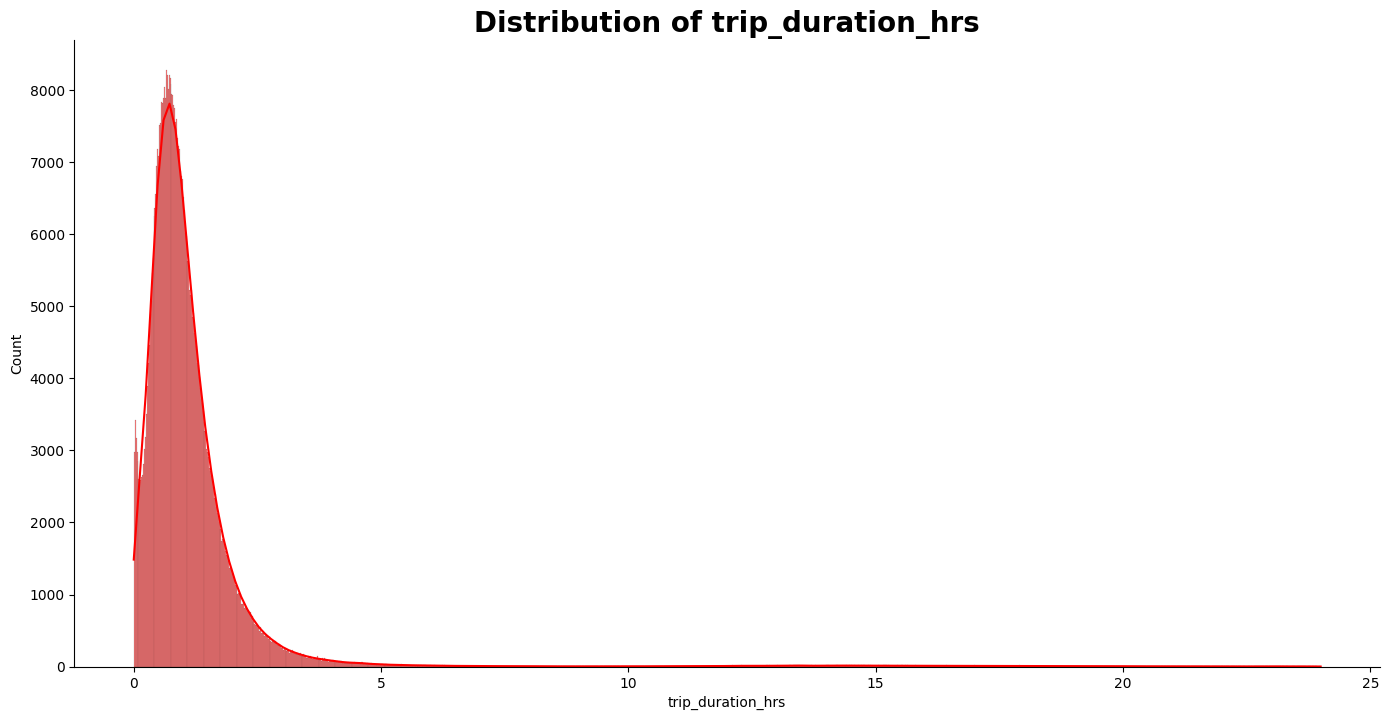

In [ ]:
plot.plot_hist(clean_orders,'trip_duration_hrs', 'red')

There are trips whose duration is too short (less than 5 minutes). Could be that these trips were cancelled

In [ ]:
df = clean_orders[clean_orders['trip_duration_hrs']<5/60]

print("{} trips have a duration less than 5 minutes, accounting to {:.2f}% of all orders.".format(len(df), len(df)/len(clean_orders)))

13573 trips have a duration less than 5 minutes, accounting to 0.03% of all orders.


## 3. Calculate Trip Distances

Since we have latitude-longitude for starting point and end point. we calculate the straight line distance and not the actual distance traveled along roads.

- we use geopy liberary for calculating distances from lat-long values

- Geopy can calculate geodesic distance between two points using the geodesic distance or the great-circle distance, with a default of the geodesic distance available as the function

In [ ]:
from geopy import distance

In [ ]:
clean_orders['distance_km'] = clean_orders.apply(lambda x: distance.distance((x['origin_lat'], x['origin_long']),
(x['destination_lat'], x['destination_long'])).km, axis=1)

In [ ]:
clean_orders['distance_km'].describe()

count    534305.000000
mean         12.023147
std           8.451186
min           0.000000
25%           5.559767
50%          10.509524
75%          16.992917
max         533.747902
Name: distance_km, dtype: float64

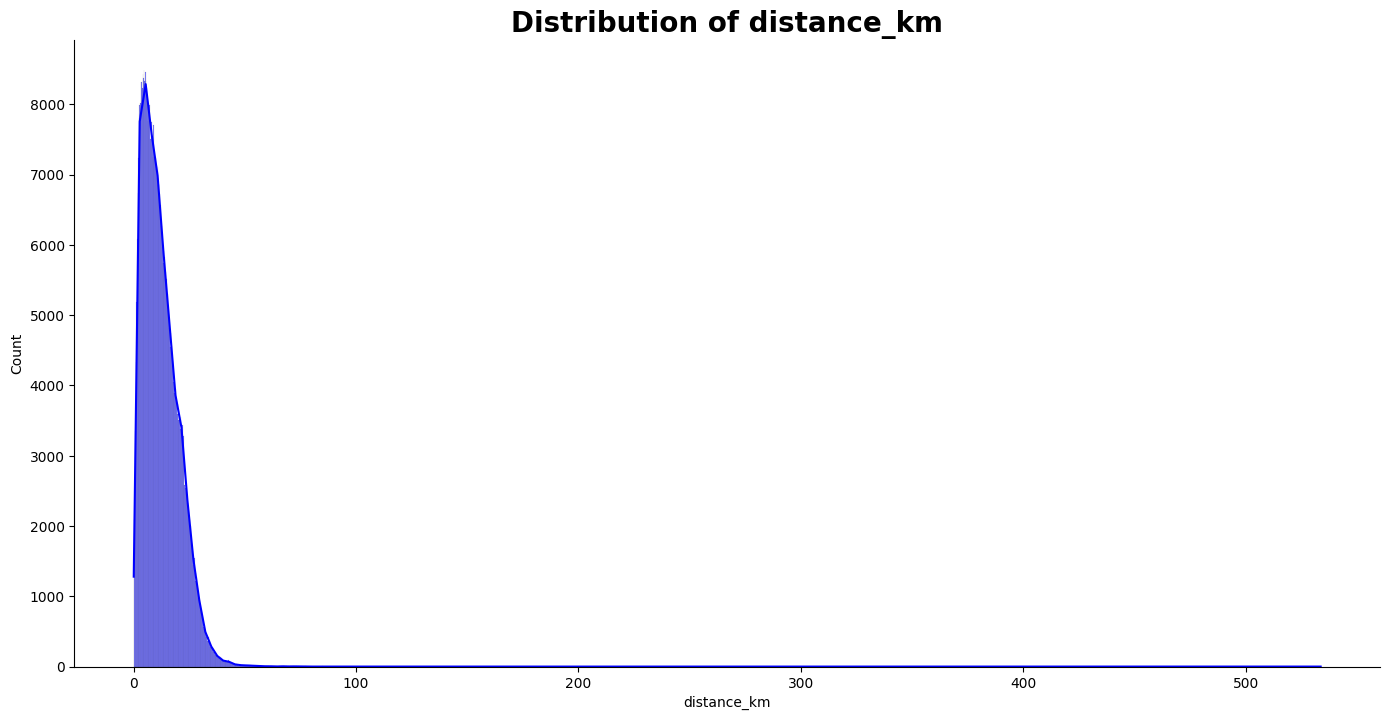

In [ ]:
plot.plot_hist(clean_orders,'distance_km', 'blue')

In [ ]:
df = clean_orders[clean_orders['distance_km']< 0.1]

print("{} trips of less than 100 meters, accounting to {:.2f}% of all orders.".format(len(df), len(df)/len(clean_orders)))

617 trips of less than 100 meters, accounting to 0.00% of all orders.


# How many drivers Per Order?

We look at the data of drivers, to answer the questions:

- how many drivers are notified per order?
- how many drivers accept or reject per order?

In [ ]:
print("full number of records is ", len(clean_driversloc))

x = clean_driversloc[['order_id', 'driver_id']].drop_duplicates()

print("However, there are only {} unique pairs of order_id & driver_id".format(len(x)))

full number of records is  718826
However, there are only 611799 unique pairs of order_id & driver_id


We make a couple of observations:

- The combination of 'order_id' + 'driver_id' almost identifies the table of driver location. Although there are cases where the are repeated:

  - There are drivers that have both 'accepted' and 'rejected' actions regarding the same order. These cases could be of a driver that accepted then rejected the order.

- Related, there are orders that get accepted by more than 1 driver. These cases could be that the first driver rejected, so another driver got to accept.

In [ ]:
df = pd.DataFrame()

df['order_id'] = clean_driversloc['order_id']

df['driver_id'] = clean_driversloc['driver_id']

df.drop_duplicates(inplace= True)


drivers_per_orders = df.groupby('order_id').count()

drivers_per_orders.rename(columns={'driver_id': 'num_drivers'}, inplace=True)

In [ ]:
drivers_per_orders.describe()

,num_drivers
count,26492.000000
mean,23.093726
std,21.222153
min,1.000000
25%,8.000000
50%,17.000000
75%,30.000000
max,215.000000


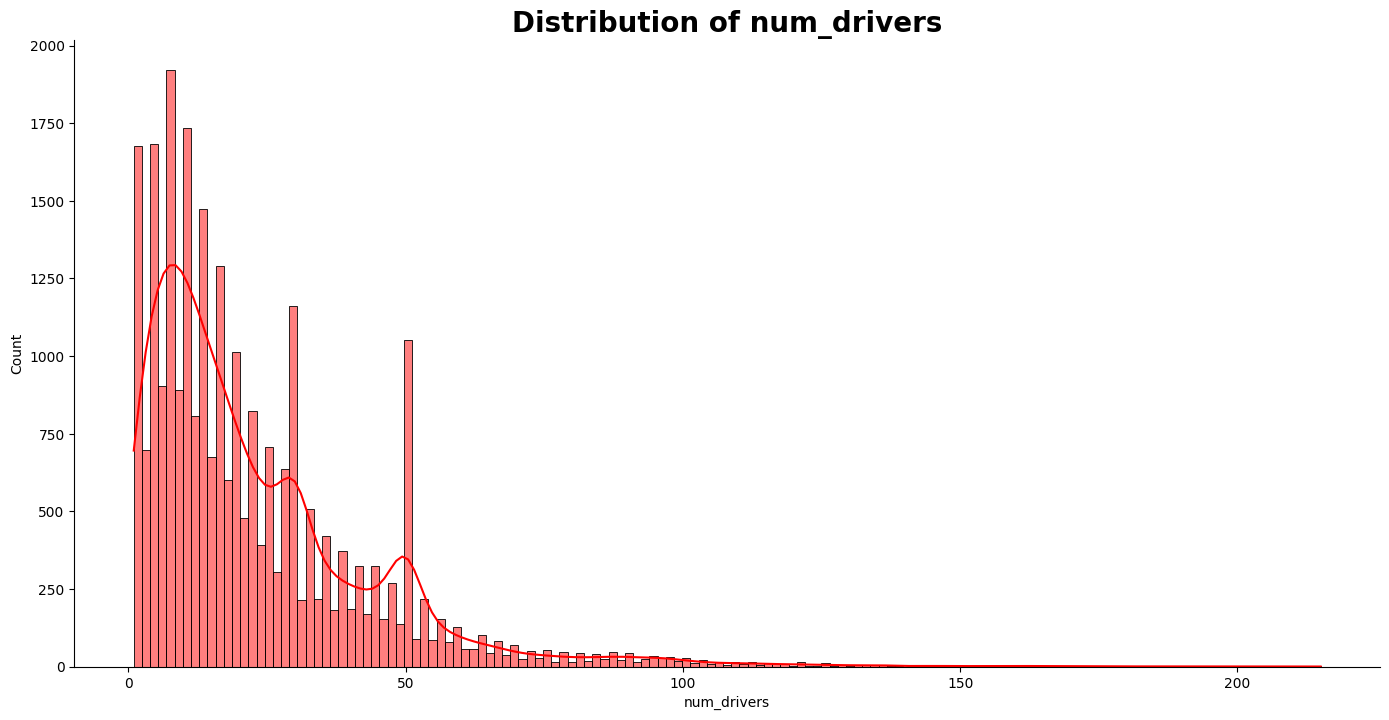

In [ ]:
plot.plot_hist(drivers_per_orders, 'num_drivers', 'red')

In [ ]:
df = pd.DataFrame()

df['order_id'] = clean_driversloc['order_id']

df['driver_id'] = clean_driversloc['driver_id']

df['drivers_accepted'] = clean_driversloc['driver_action'].apply(lambda x: 1 if x == 'accepted' else 0)

df['drivers_rejected'] = clean_driversloc['driver_action'].apply(lambda x: 1 if x == 'rejected' else 0)



sorted_drivers_per_order = df.groupby('order_id').agg({'drivers_accepted': 'sum', 'drivers_rejected': 'sum'})

In [ ]:
sorted_drivers_per_order.describe()

,drivers_accepted,drivers_rejected
count,26492.000000,26492.000000
mean,0.977767,26.155934
std,0.152972,29.919345
min,0.000000,0.000000
25%,1.000000,8.000000
50%,1.000000,17.000000
75%,1.000000,34.000000
max,2.000000,499.000000


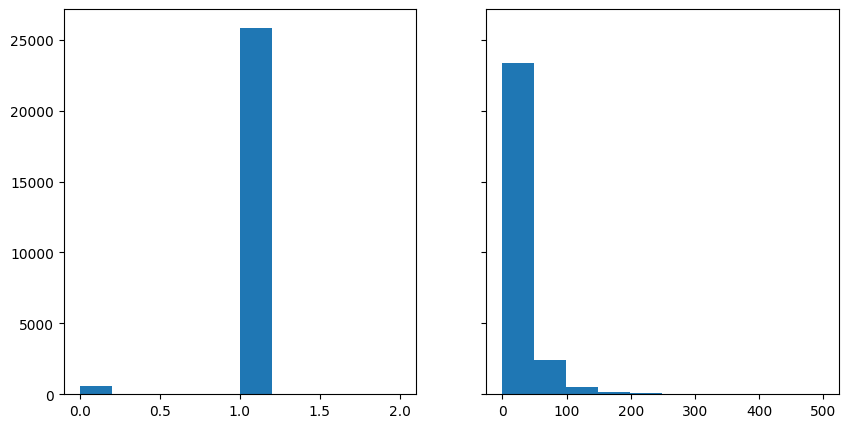

In [ ]:
_, axes = plt.subplots(1,2, figsize= (10,5), sharey= True)

axes[0].hist(x = sorted_drivers_per_order['drivers_accepted'])
axes[1].hist(x = sorted_drivers_per_order['drivers_rejected'])

plt.show()

# Merge order and drivers-location dataframes

We need to merge the two dataframes of fulfilled orders and dirvers locations at request to answer questions like:

- How far are the Drivers at request?

## 1. Merge the two dataframes

In [ ]:
clean_orders.rename(columns={'distance_km': 'trip_distance_km'}, inplace=True)

clean_orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 534305 entries, 0 to 536019
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype          
---  ------             --------------   -----          
 0   trip_id            534305 non-null  int64          
 1   trip_start_time    534305 non-null  datetime64[ns] 
 2   trip_end_time      534305 non-null  datetime64[ns] 
 3   origin_lat         534305 non-null  float64        
 4   origin_long        534305 non-null  float64        
 5   destination_lat    534305 non-null  float64        
 6   destination_long   534305 non-null  float64        
 7   trip_duration      534305 non-null  timedelta64[ns]
 8   trip_duration_hrs  534305 non-null  float64        
 9   trip_distance_km   534305 non-null  float64        
dtypes: datetime64[ns](2), float64(6), int64(1), timedelta64[ns](1)
memory usage: 61.0 MB


In [ ]:
clean_driversloc.rename(columns={'lat': 'driver_lat', 'lng': 'driver_lng'}, inplace=True)

clean_driversloc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 718826 entries, 0 to 1557731
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   order_id       718826 non-null  int64  
 1   driver_id      718826 non-null  int64  
 2   driver_action  718826 non-null  object 
 3   driver_lat     718826 non-null  float64
 4   driver_lng     718826 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 32.9+ MB


In [ ]:
df_merged = pd.merge(clean_orders, clean_driversloc, how= 'inner', left_on= 'trip_id', right_on= 'order_id')

In [ ]:
df_merged.drop(columns=['order_id'], inplace= True)

df_merged.rename(columns={'trip_id': 'order_id'}, inplace= True)

df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 717832 entries, 0 to 717831
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype          
---  ------             --------------   -----          
 0   order_id           717832 non-null  int64          
 1   trip_start_time    717832 non-null  datetime64[ns] 
 2   trip_end_time      717832 non-null  datetime64[ns] 
 3   origin_lat         717832 non-null  float64        
 4   origin_long        717832 non-null  float64        
 5   destination_lat    717832 non-null  float64        
 6   destination_long   717832 non-null  float64        
 7   trip_duration      717832 non-null  timedelta64[ns]
 8   trip_duration_hrs  717832 non-null  float64        
 9   trip_distance_km   717832 non-null  float64        
 10  driver_id          717832 non-null  int64          
 11  driver_action      717832 non-null  object         
 12  driver_lat         717832 non-null  float64        
 13  driver_lng         717832 non

## 2. Calculate distances driver-trip origin 

In [ ]:
from geopy import distance

In [ ]:
df_merged['driver-origin_km'] = df_merged.apply(lambda x: distance.distance((x['origin_lat'], x['origin_long']),
(x['driver_lat'], x['driver_lng'])).km, axis=1)

In [ ]:
df_merged['driver-dest_km'] = df_merged.apply(lambda x: distance.distance((x['destination_lat'], x['destination_long']),
(x['driver_lat'], x['driver_lng'])).km, axis=1)

In [ ]:
df_merged[['driver-origin_km', 'driver-dest_km']].describe()

,driver-origin_km,driver-dest_km
count,717832.000000,7.178320e+05
mean,1.790051,9.525378e+00
std,1.088520,6.873024e+00
min,0.000000,3.071491e-12
25%,1.067051,4.402384e+00
50%,1.687462,7.806586e+00
75%,2.398366,1.298262e+01
max,210.887483,7.754643e+01


Looking at the max value (>200km) and the 75% quantile (< 3 km). it is clear that there are outliers.

Since there are other values (lat-lng and driver_action) that are related to distance, we handle the outliers by removing them

In [ ]:
df = cleaned.drop_outlier(df_merged, 'driver-origin_km', alpha= 0.001)
#df = cleaned.drop_outlier(df, 'driver-dest_km', alpha= 0.001)

In [ ]:
print(len(df_merged) - len(df))

718


In [ ]:
df[['driver-origin_km', 'driver-dest_km']].describe()

,driver-origin_km,driver-dest_km
count,717114.000000,7.171140e+05
mean,1.781717,9.524269e+00
std,1.000189,6.871140e+00
min,0.000000,3.071491e-12
25%,1.066275,4.402695e+00
50%,1.686382,7.805612e+00
75%,2.395390,1.298069e+01
max,4.986761,7.754643e+01


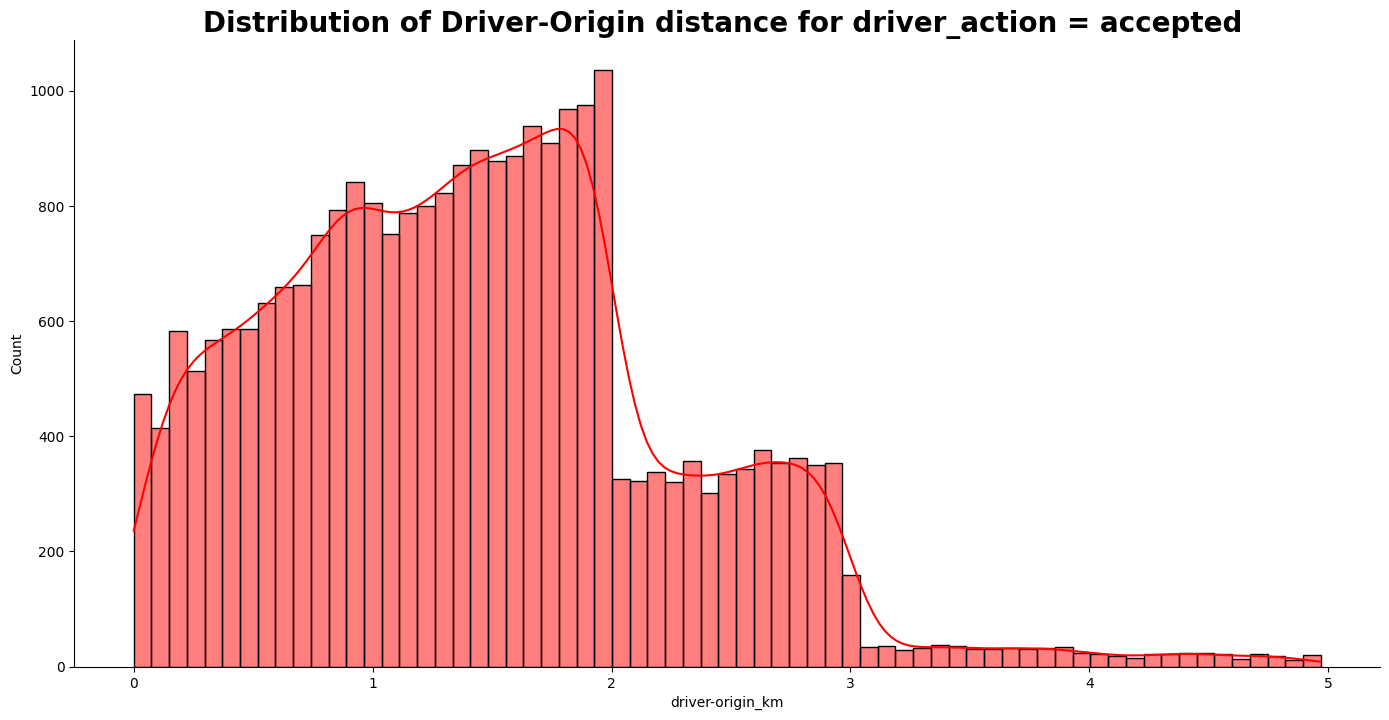

In [ ]:
# for driver action= 'accepted

sns.displot(data=df[df['driver_action']=='accepted'], x= 'driver-origin_km', color='red', kde=True, height=7, aspect=2)
plt.title('Distribution of Driver-Origin distance for driver_action = accepted ', size=20, fontweight='bold')
plt.show()

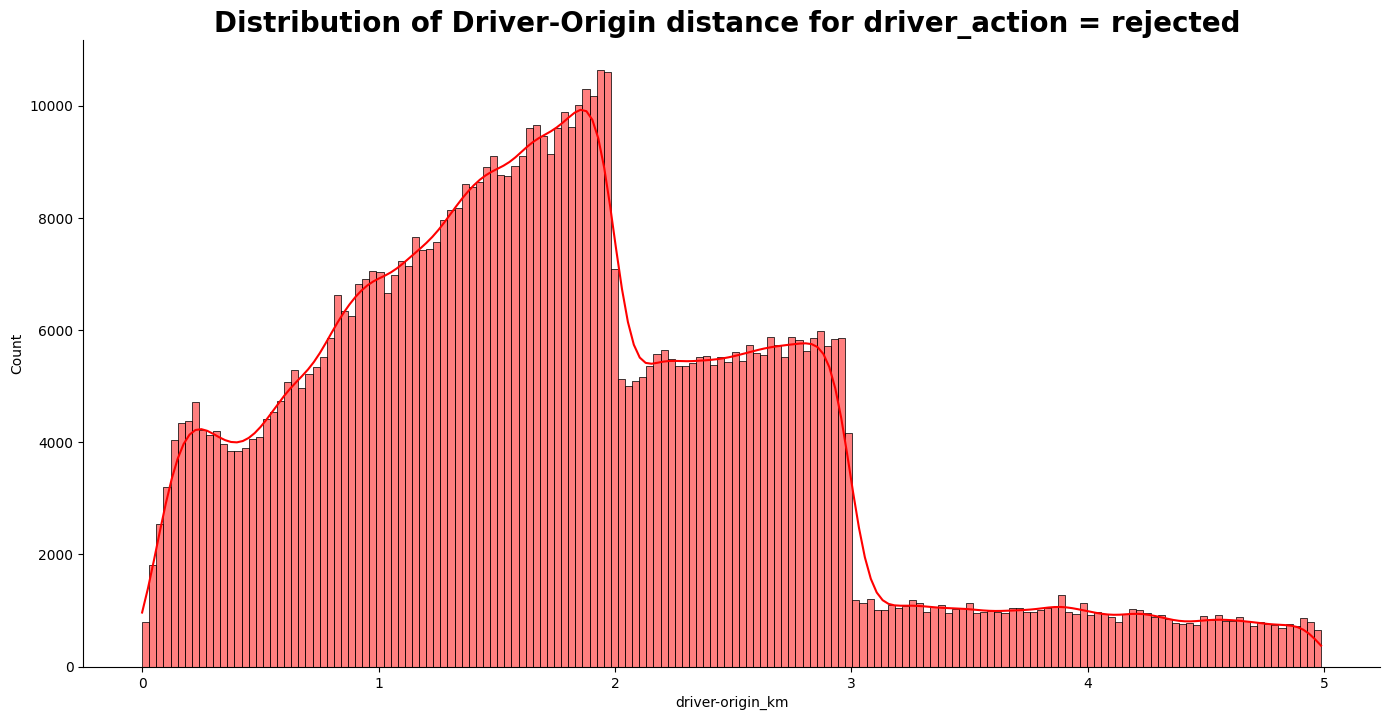

In [ ]:
# for driver action= 'rejected'

sns.displot(data=df[df['driver_action']=='rejected'], x= 'driver-origin_km', color='red', kde=True, height=7, aspect=2)
plt.title('Distribution of Driver-Origin distance for driver_action = rejected ', size=20, fontweight='bold')
plt.show()

After removing the outliers, the distribution for driver-origin distance looks similar for driver_action = 'accepted' and 'rejected'

## 3. Number of drivers within 500 m from Order

In [ ]:
df500 = df[df['driver-origin_km'] <= 0.5]

In [ ]:
drivers_within500m = df500.groupby('order_id').agg({'trip_duration_hrs': 'mean', 'trip_distance_km': 'mean','driver_id': 'count', 
'driver-origin_km': 'mean', 'driver-dest_km': 'mean'})

In [ ]:
drivers_within500m.describe()

,trip_duration_hrs,trip_distance_km,driver_id,driver-origin_km,driver-dest_km
count,15139.000000,15139.000000,15139.000000,15139.000000,1.513900e+04
mean,0.992006,10.530392,4.240306,0.307752,1.053081e+01
std,1.547779,7.432151,7.909841,0.112178,7.433185e+00
min,0.005000,0.016387,1.000000,0.000000,3.071491e-12
25%,0.445833,4.785129,1.000000,0.232972,4.786964e+00
50%,0.732222,8.847153,2.000000,0.318550,8.853055e+00
75%,1.124167,14.742229,3.000000,0.393565,1.473244e+01
max,23.793056,77.546433,101.000000,0.499967,7.754643e+01


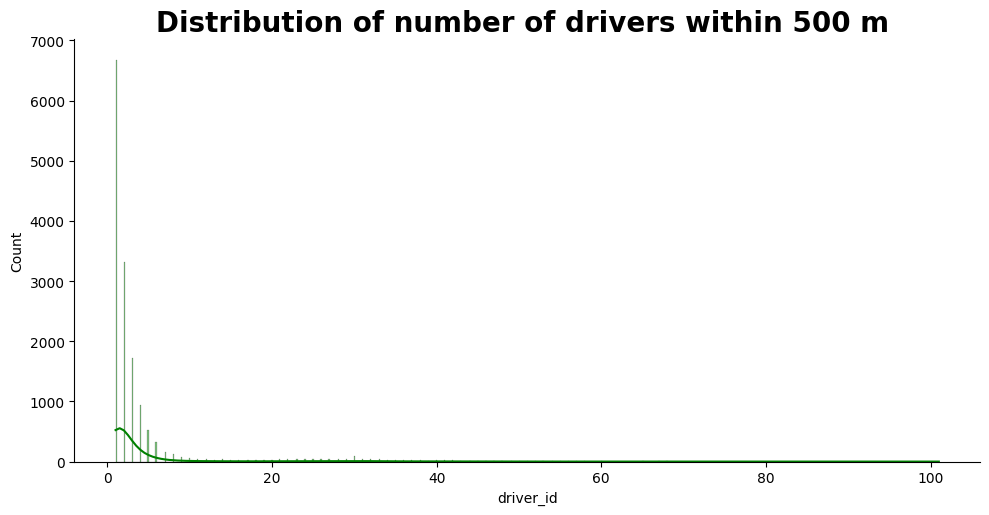

In [ ]:
sns.displot(drivers_within500m, x= 'driver_id', color='green', kde=True, height=5, aspect=2)
plt.title('Distribution of number of drivers within 500 m ', size=20, fontweight='bold')
plt.show()

For most cases, there are less than 5 drivers within 500 m of an order.

# Write out the data

In [ ]:
clean_orders.to_csv('../data/orders.csv', index=False)

In [ ]:
clean_driversloc.to_csv('../data/drivers_locations_during_request.csv', index=False)

In [ ]:
df_merged.to_csv("../data/full_merged.csv", index=False)

In [ ]:
df.to_csv("../data/clean_merged.csv", index=False)

In [ ]:
# data_url = explore.get_data_url("data/orders.csv", "v4")
# clean_orders = pd.read_csv(data_url)

# data_url = explore.get_data_url("data/drivers_locations_during_request.csv", "v4")
# clean_driversloc = pd.read_csv(data_url)

# data_url = explore.get_data_url("data/full_merged.csv", "v4")
# df_merged= pd.read_csv(data_url)